In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Extraction & Pre-processing

### Extracting the dataset

In [ ]:
#!unzip /content/drive/MyDrive/trainval.zip -d /content/drive/MyDrive/full_data

### Preprocessing: Convert COCO JSON to YOLO format

In [ ]:
# Code adapted from Haobin Tan's blog: https://haobin-tan.netlify.app/ai/computer-vision/object-detection/coco-json-to-yolo-txt/

import os
import json
from tqdm import tqdm
import shutil

def make_folders(path="output"):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def convert_bbox_coco2yolo(img_width, img_height, bbox):
    """
    Convert bounding box from COCO  format to YOLO format

    Parameters
    ----------
    img_width : int
        width of image
    img_height : int
        height of image
    bbox : list[int]
        bounding box annotation in COCO format: [top left x position, top left y position, width, height]

    Returns
    -------
    list[float]: bounding box annotation in YOLO format: [x_center_rel, y_center_rel, width_rel, height_rel]
    """
    
    # YOLO bounding box format: [x_center, y_center, width, height]
    # (float values relative to width and height of image)
    x_tl, y_tl, w, h = bbox

    dw = 1.0 / img_width
    dh = 1.0 / img_height

    # YOLO annotations are with normalized box dimensions
    x_center = x_tl + w / 2.0
    y_center = y_tl + h / 2.0

    x = x_center * dw
    y = y_center * dh
    w = w * dw
    h = h * dh

    return [x, y, w, h]

def convert_coco_json_to_yolo_txt(output_path, json_file):

    path = make_folders(output_path)

    with open(json_file) as f:
        json_data = json.load(f)

    # write _darknet.labels, which holds names of all classes (one class per line)
    label_file = os.path.join(output_path, "_darknet.labels")
    with open(label_file, "w") as f:
        for category in tqdm(json_data["categories"], desc="Categories"):
            category_name = category["name"]
            f.write(f"{category_name}\n")

    # Process each image one by one and generate corresponding .txt file
    for image in tqdm(json_data["images"], desc="Annotation txt for each iamge"):
        img_id = image["id"]
        img_name = image["file_name"]
        img_width = image["width"]
        img_height = image["height"]

        anno_in_image = [anno for anno in json_data["annotations"] if anno["image_id"] == img_id]
        anno_txt = os.path.join(output_path, img_name.split(".")[0] + ".txt")
        with open(anno_txt, "w") as f:
            for anno in anno_in_image:
                category = anno["category_id"] - 1
                bbox_COCO = anno["bbox"]
                x, y, w, h = convert_bbox_coco2yolo(img_width, img_height, bbox_COCO)
                f.write(f"{category} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

    print("Converting COCO Json to YOLO txt finished!")

In [ ]:
convert_coco_json_to_yolo_txt("/content/drive/MyDrive/full_data/trainval/text_annots", "/content/drive/MyDrive/full_data/trainval/annotations/bbox-annotations.json")

Annotation txt for each iamge: 100%|██████████| 2239/2239 [00:26<00:00, 85.47it/s]

Converting COCO Json to YOLO txt finished!


## Data Analysis & Preparation

### Preliminary Analysis

#### Image count

In [ ]:
! ls /content/drive/MyDrive/full_data/trainval/images/ | wc -l

2239


#### Text annotations count

In [ ]:
! ls /content/drive/MyDrive/full_data/trainval/text_annots/ | grep .txt | wc -l

2239


The count of images and annotations match.

In [ ]:
# Combining images and generated text annotations into asingle folder
!cp -r /content/drive/MyDrive/full_data/trainval/images/* /content/drive/MyDrive/full_data/trainval/text_annots/

### Exploratory Analysis: Box Counts

In [ ]:
import os
import random
import pandas as pd
from tqdm import tqdm

In [ ]:
classnames = ["person", "car"]

def gt_cls_count(input_imgs_dir):
  """
  Function to get image wise box counts as a Pandas DataFrame

  Parameters
  ----------
  input_imgs_dir : str
        Path to the folder containing all images and annotations
  Returns
    -------
    Pandas DataFrame: A DataFrame object containing class-wise box counts per image
  """
  cls_counts_zero = {cls:0 for cls in classnames}
    
  all_files = [i.rsplit('.',1)[0] for i in os.listdir(input_imgs_dir) if i.endswith('.jpg')]

  print('\nNumber of images found in input folder:', len(all_files))
    
  img_cls_counts_list = []
  counter = 0

  # Process each annotation file for existing images
  for file_name in tqdm(all_files):
    img_cls_counts = {'image_key': file_name+'.jpg'}
    img_cls_counts.update(cls_counts_zero)

    if os.path.exists(os.path.join(input_imgs_dir,file_name+'.txt')):
      with open(os.path.join(input_imgs_dir,file_name+'.txt'),'r') as f:
        annotations = [i.strip().split() for i in f.readlines()]

      for i in annotations:
        if len(i)>0:
          cls_name = classnames[int(i[0])]
          img_cls_counts[cls_name] += 1
                    
      img_cls_counts_list.append(img_cls_counts)
      counter += 1

  print('\nNumber of annotated images:', counter)
            
  count_df = pd.DataFrame.from_dict(img_cls_counts_list)

  return count_df

In [ ]:
count_df = gt_cls_count(input_imgs_dir="/content/drive/MyDrive/full_data/trainval/text_annots")


Number of images found in input folder: 2239


100%|██████████| 2239/2239 [00:07<00:00, 309.38it/s]


Number of annotated images: 2239


In [ ]:
# View of the generated count DataFrame
count_df.head()

image_key  person  car
0  image_000000001.jpg       2    2
1  image_000000002.jpg       1    2
2  image_000000003.jpg      11    1
3  image_000000004.jpg       1    1
4  image_000000005.jpg       9    1

In [ ]:
count_df[['person', 'car']].sum()

person    10800
car        5972
dtype: int64

Thus, **we observe a severe imblance in the number of person sample objects, and car sample objects.**

#### Number of images with only "person" objects

In [ ]:
person_df = count_df[count_df['car']==0]
len(person_df)

0

#### Data Balancing

As no samples exist with only person object, the data balancing must be done in a way such that minimal reduction in the car object numbers is caused.

In [ ]:
person_df = count_df[count_df['car'] < count_df['person']]

In [ ]:
# DataFrames to contain images with more person objects than car objects are selected.
# First I take the DataFrame of images with only 1 car object and many person objects, and sorted it highest to least by person count.
# Second wI take the DataFrame of images with only 2 car objects and many person objects, and sorted it highest to least by person count.

person_dom1_df = person_df[person_df['car']==1].sort_values('person', ascending=False)
person_dom2_df = person_df[person_df['car']==2].sort_values('person', ascending=False)

In [ ]:
person_dom1_df.head()

image_key  person  car
833   image_000000834.jpg      30    1
357   image_000000358.jpg      30    1
1862  image_000001863.jpg      27    1
391   image_000000392.jpg      26    1
2036  image_000002037.jpg      25    1

In [ ]:
# Here we attempt to reduce the count of person objects by 4000 with minimal reduction to car objects.
# All samples from the first dataframe are not removed, since doing that would alter the dynamics of the natural data.

total_person = 10800
sample_person_count = 0
sample_car_count = 0
sample_df = []

# Get some images from the first dataframe to be removed. The probability of selection of an image from this DataFrame is 90% (for each image).
for ix, row in person_dom1_df.iterrows():
  to_select = random.random()
  if to_select < 0.9 and sample_person_count < 4000:
    sample_df.append(row)
    sample_person_count += row['person']
    sample_car_count += row['car']
  elif sample_person_count > 4000:
    break

# Get some images from the second dataframe to be removed. The probability of selection of an image from this DataFrame is 80% (for each image).
for ix, row in person_dom2_df.iterrows():
  to_select = random.random()
  if to_select < 0.8 and sample_person_count < 4000:
    sample_df.append(row)
    sample_person_count += row['person']
    sample_car_count += row['car']
  elif sample_person_count > 4000:
    break

In [ ]:
sample_person_count

4000

In [ ]:
sample_car_count

658

In [ ]:
# Reduced number of person objects
10800 - 4000

6800

In [ ]:
# Reduced number of car objects
5972 - 658

5314

Although complete balance is not possible, 6800 and 5314 is closer than 10800 and 917.

In [ ]:
# Removing the images to get data balance
import shutil

source = "/content/drive/MyDrive/full_data/trainval/text_annots"
target = "/content/drive/MyDrive/full_data/trainval/outsampled"

for row in sample_df:
  fn = row['image_key']

  shutil.move(os.path.join(source, fn), target)
  shutil.move(os.path.join(source, fn.split('.')[0]+'.txt'), target)

In [ ]:
count_df = gt_cls_count(input_imgs_dir="/content/drive/MyDrive/full_data/trainval/text_annots")


Number of images found in input folder: 1644


100%|██████████| 1644/1644 [00:05<00:00, 300.30it/s]


Number of annotated images: 1644


In [ ]:
count_df[['person', 'car']].sum()

person    6800
car       5314
dtype: int64

### Data Split For Modelling

#### Train set: 70%

In [ ]:
import fnmatch

image_set = fnmatch.filter(os.listdir("/content/drive/MyDrive/full_data/trainval/text_annots"), '*.jpg')

In [ ]:
len(image_set)

1644

In [ ]:
train_imgs = random.sample(image_set, int(len(image_set)*0.70))

len(train_imgs)

1150

In [ ]:
source = "/content/drive/MyDrive/full_data/trainval/text_annots"
dest = "/content/drive/MyDrive/full_data/Modelling_Data/train"

for img in train_imgs:
  shutil.move(os.path.join(source, img), dest)
  shutil.move(os.path.join(source, img.split('.')[0]+'.txt'), dest)

#### Valid Set: 15%

In [ ]:
# After removal of 70%, 15% of whole is 50% of the remaining

image_set = fnmatch.filter(os.listdir("/content/drive/MyDrive/full_data/trainval/text_annots"), '*.jpg')
print(len(image_set))

valid_imgs = random.sample(image_set, int(len(image_set)*0.50))
print(len(valid_imgs))

494
247


In [ ]:
source = "/content/drive/MyDrive/full_data/trainval/text_annots"
dest = "/content/drive/MyDrive/full_data/Modelling_Data/valid"

for img in valid_imgs:
  shutil.move(os.path.join(source, img), dest)
  shutil.move(os.path.join(source, img.split('.')[0]+'.txt'), dest)

Test Set: 15%

In [ ]:
# Remaining after removing train, and valid sets.

source = "/content/drive/MyDrive/full_data/trainval/text_annots"
dest = "/content/drive/MyDrive/full_data/Modelling_Data/test"

test_imgs = fnmatch.filter(os.listdir(source), '*.jpg')
print(len(test_imgs))

for img in test_imgs:
  shutil.move(os.path.join(source, img), dest)
  shutil.move(os.path.join(source, img.split('.')[0]+'.txt'), dest)

247


### Class-wise Distribution Affter Data Splitting

#### Train set

In [ ]:
train_df = gt_cls_count(input_imgs_dir="/content/drive/MyDrive/full_data/Modelling_Data/train")
train_df[['person', 'car']].sum()


Number of images found in input folder: 1150


100%|██████████| 1150/1150 [00:04<00:00, 285.15it/s]


Number of annotated images: 1150


person    4648
car       3730
dtype: int64

#### Valid set

In [ ]:
valid_df = gt_cls_count(input_imgs_dir="/content/drive/MyDrive/full_data/Modelling_Data/valid")
valid_df[['person', 'car']].sum()


Number of images found in input folder: 247


100%|██████████| 247/247 [00:00<00:00, 252.37it/s]


Number of annotated images: 247


person    1044
car        746
dtype: int64

#### Test Set

In [ ]:
test_df = gt_cls_count(input_imgs_dir="/content/drive/MyDrive/full_data/Modelling_Data/test")
test_df[['person', 'car']].sum()


Number of images found in input folder: 247


100%|██████████| 247/247 [00:01<00:00, 223.30it/s]


Number of annotated images: 247


person    1108
car        838
dtype: int64

## Data Modelling

### Setup
For modelling the object detection problem I'll be using the open-source repository for YOLOv5 implementation by Ultralytics

In [ ]:
#!git clone https://github.com/ultralytics/yolov5 /content/drive/MyDrive/YOLO/

Cloning into '/content/drive/MyDrive/YOLO'...
remote: Enumerating objects: 12251, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 12251 (delta 10), reused 9 (delta 5), pack-reused 12229
Receiving objects: 100% (12251/12251), 11.94 MiB | 6.37 MiB/s, done.
Resolving deltas: 100% (8480/8480), done.


In [ ]:
%cd /content/drive/MyDrive/YOLO

/content/drive/MyDrive/YOLO


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 7.8 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Training

In [ ]:
!python train.py -h

usage: train.py [-h] [--weights WEIGHTS] [--cfg CFG] [--data DATA] [--hyp HYP]
                [--epochs EPOCHS] [--batch-size BATCH_SIZE] [--imgsz IMGSZ]
                [--rect] [--resume [RESUME]] [--nosave] [--noval]
                [--noautoanchor] [--noplots] [--evolve [EVOLVE]]
                [--bucket BUCKET] [--cache [CACHE]] [--image-weights]
                [--device DEVICE] [--multi-scale] [--single-cls]
                [--optimizer {SGD,Adam,AdamW}] [--sync-bn] [--workers WORKERS]
                [--project PROJECT] [--name NAME] [--exist-ok] [--quad]
                [--cos-lr] [--label-smoothing LABEL_SMOOTHING]
                [--patience PATIENCE] [--freeze FREEZE [FREEZE ...]]
                [--save-period SAVE_PERIOD] [--local_rank LOCAL_RANK]
                [--entity ENTITY] [--upload_dataset [UPLOAD_DATASET]]
                [--bbox_interval BBOX_INTERVAL]
                [--artifact_alias ARTIFACT_ALIAS]

optional arguments:
  -h, --help            show this hel

In [ ]:
!python train.py \
--img 512 \
--batch 8 \
--epochs 70 \
--hyp /content/drive/MyDrive/YOLO/data/hyps/hyp.VOC.yaml \
--data /content/drive/MyDrive/full_data/Modelling_Data/data.yaml \
--weights /content/drive/MyDrive/YOLO/eagleview/exp2_5x/weights/best.pt \
--project eagleview \
--name exp2_5x_pt2

train: weights=/content/drive/MyDrive/YOLO/eagleview/exp2_5x/weights/best.pt, cfg=, data=/content/drive/MyDrive/full_data/Modelling_Data/data.yaml, hyp=/content/drive/MyDrive/YOLO/data/hyps/hyp.VOC.yaml, epochs=70, batch_size=8, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=eagleview, name=exp2_5x_pt2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-252-g6a67594 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.00334, lrf=0.15135, momentum=0.74832, weight_decay=0.00025, warmup_epochs=3.3835, warmup_momentum=0.59462, warmup_bias_lr=

### Testing & Results

In [ ]:
!python val.py -h

usage: val.py [-h] [--data DATA] [--weights WEIGHTS [WEIGHTS ...]]
              [--batch-size BATCH_SIZE] [--imgsz IMGSZ]
              [--conf-thres CONF_THRES] [--iou-thres IOU_THRES] [--task TASK]
              [--device DEVICE] [--workers WORKERS] [--single-cls] [--augment]
              [--verbose] [--save-txt] [--save-hybrid] [--save-conf]
              [--save-json] [--project PROJECT] [--name NAME] [--exist-ok]
              [--half] [--dnn]

optional arguments:
  -h, --help            show this help message and exit
  --data DATA           dataset.yaml path
  --weights WEIGHTS [WEIGHTS ...]
                        model.pt path(s)
  --batch-size BATCH_SIZE
                        batch size
  --imgsz IMGSZ, --img IMGSZ, --img-size IMGSZ
                        inference size (pixels)
  --conf-thres CONF_THRES
                        confidence threshold
  --iou-thres IOU_THRES
                        NMS IoU threshold
  --task TASK           train, val, test, speed or study
 

#### Results on the validation set

In [ ]:
!python val.py \
--imgsz 512 \
--batch-size 4 \
--data /content/drive/MyDrive/full_data/Modelling_Data/data.yaml \
--weights /content/drive/MyDrive/YOLO/eagleview/exp2_5x_pt2/weights/best.pt \
--project results/eagleview \
--name exp2_5_pt2_val

val: data=/content/drive/MyDrive/full_data/Modelling_Data/data.yaml, weights=['/content/drive/MyDrive/YOLO/eagleview/exp2_5x_pt2/weights/best.pt'], batch_size=4, imgsz=512, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=results/eagleview, name=exp2_5_pt2_val, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-252-g6a67594 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86180143 parameters, 0 gradients
val: Scanning '/content/drive/MyDrive/full_data/Modelling_Data/valid.cache' images and labels... 247 found, 0 missing, 0 empty, 0 corrupt: 100% 247/247 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 62/62 [00:09<00:00,  6.23it/s]
                 all        247       1790      0.769      0.691      0.729      0.448
              

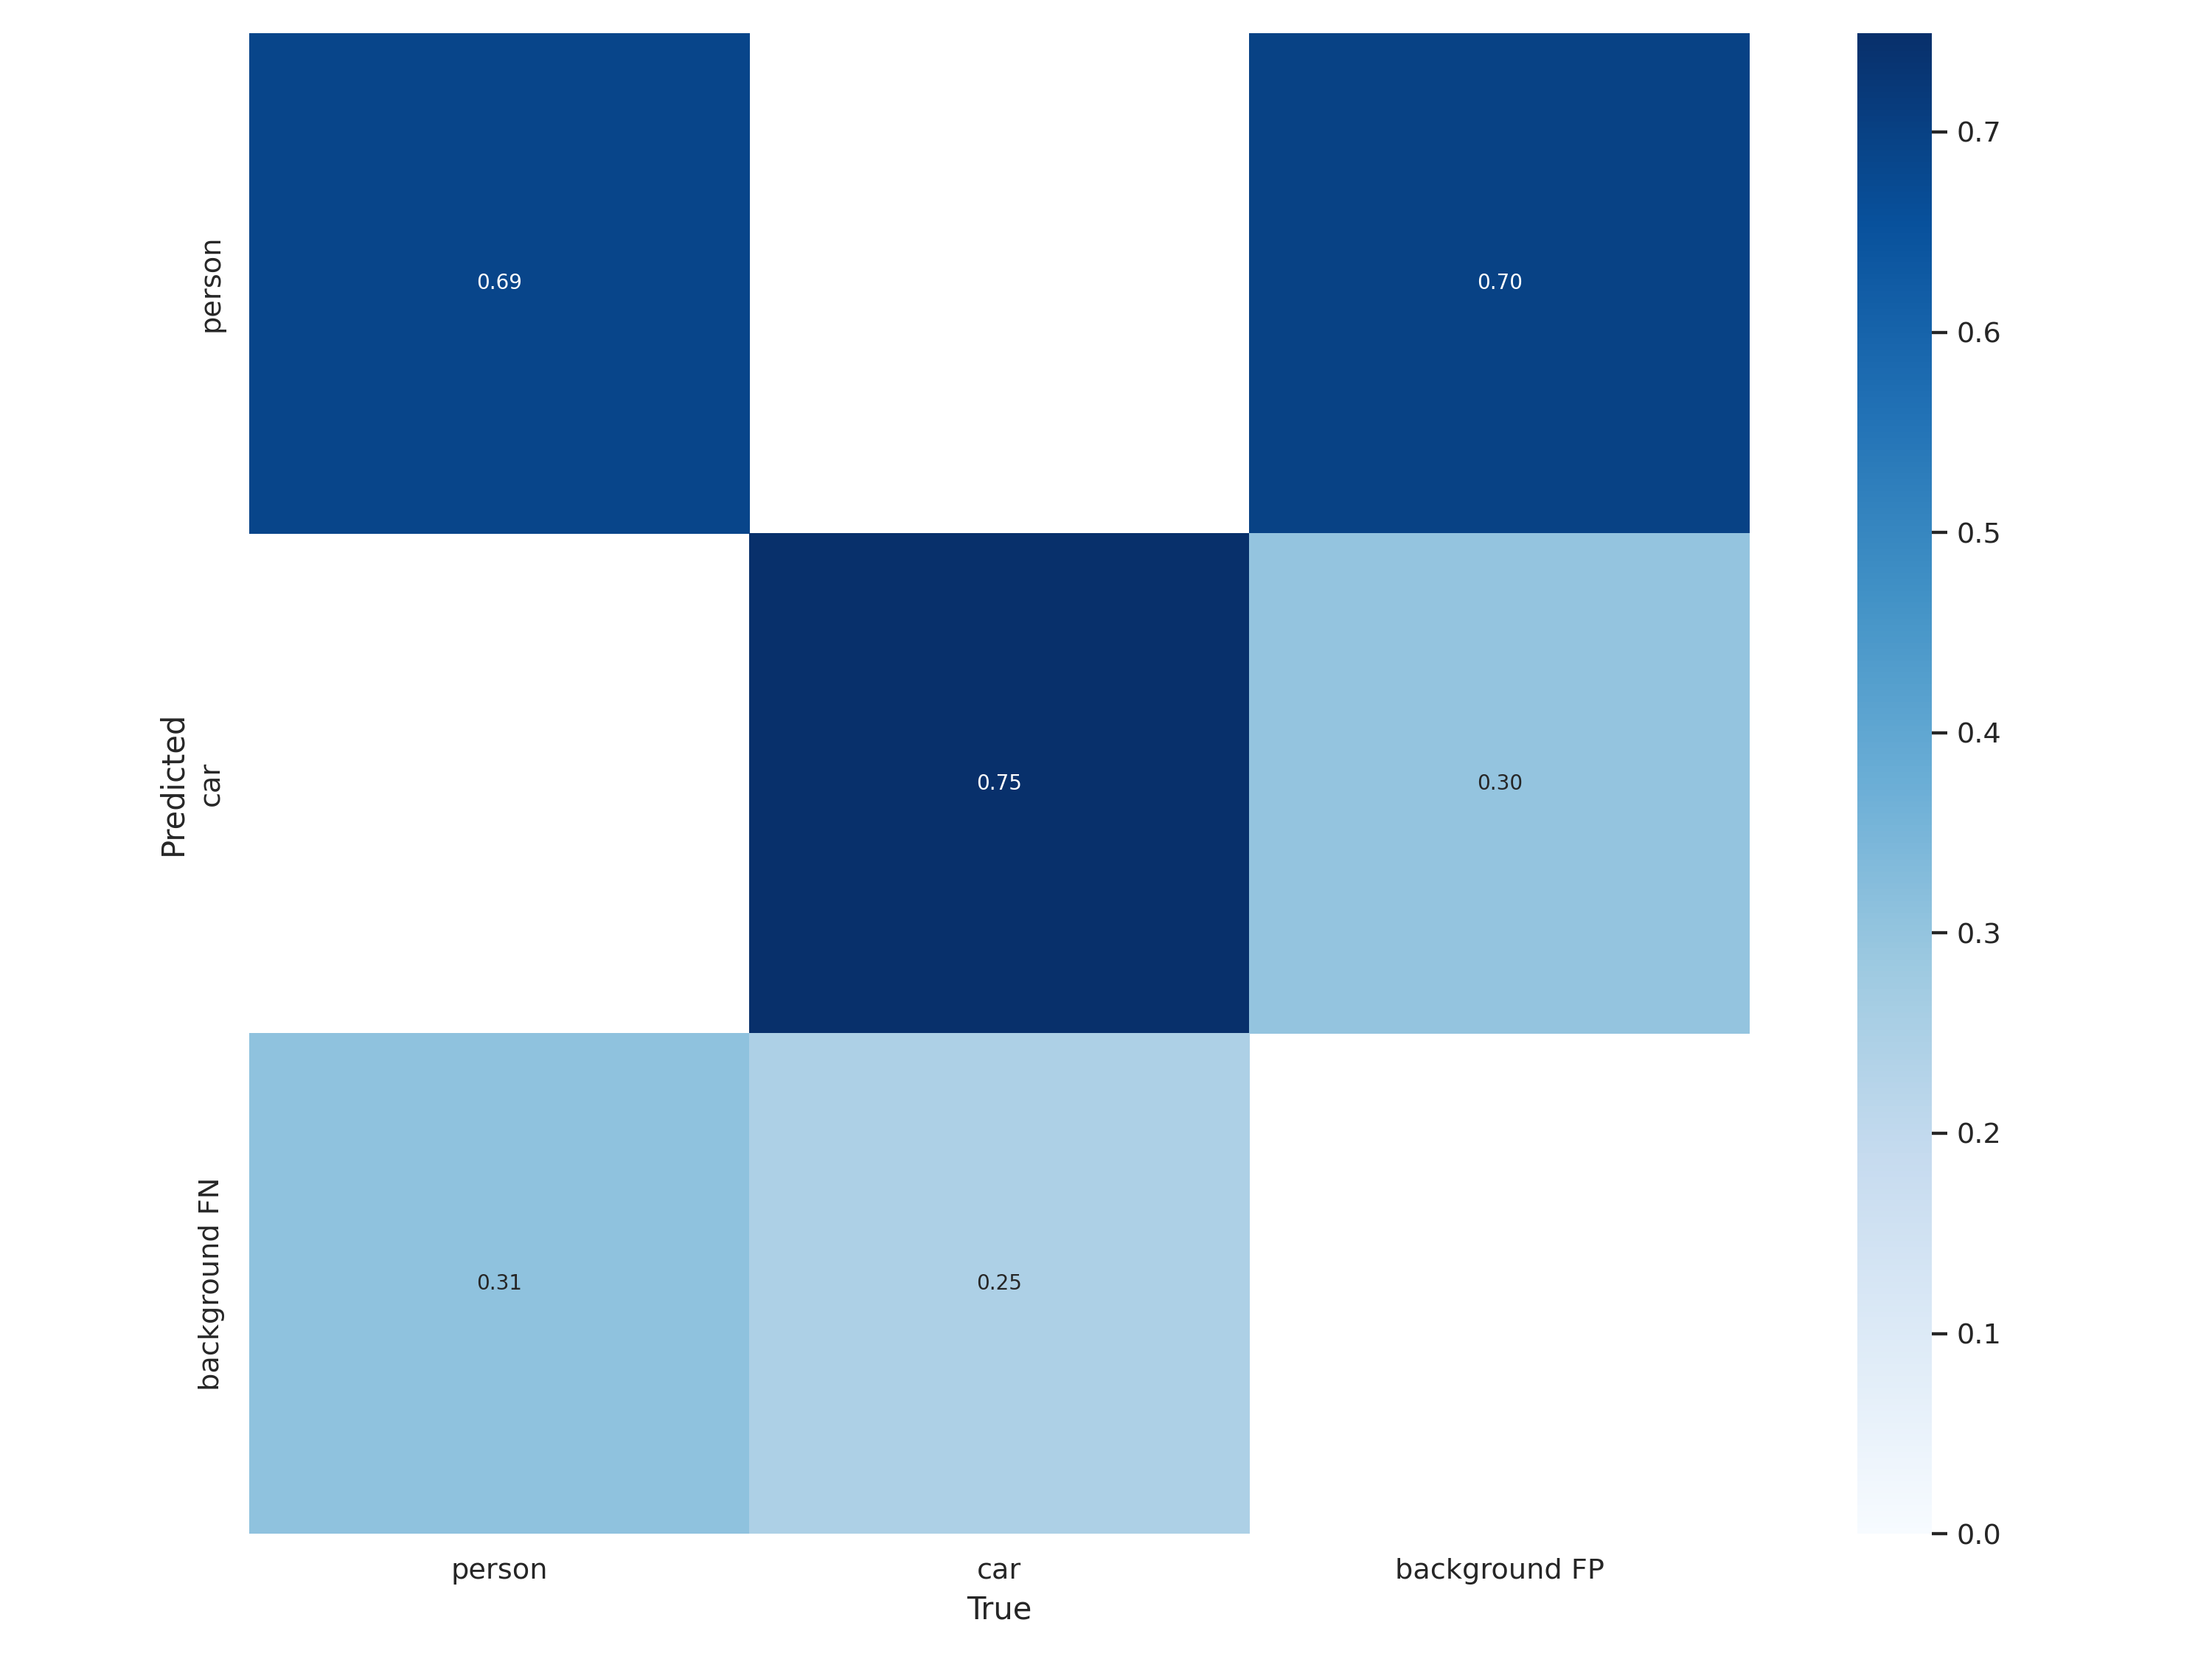

In [ ]:
from PIL import Image

display(Image.open("/content/drive/MyDrive/YOLO/results/eagleview/exp2_5_pt2_val/confusion_matrix.png"))

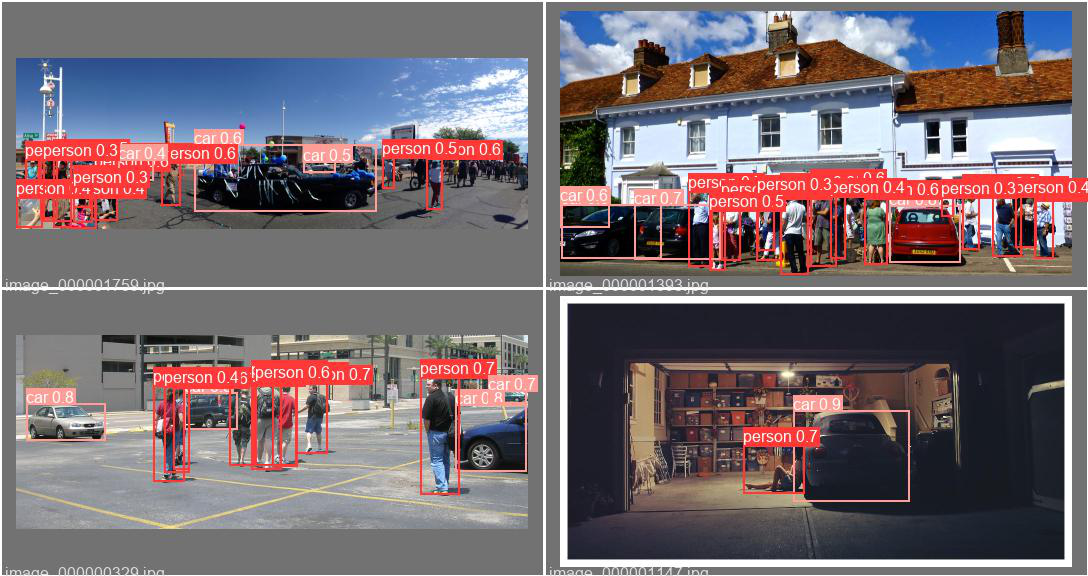

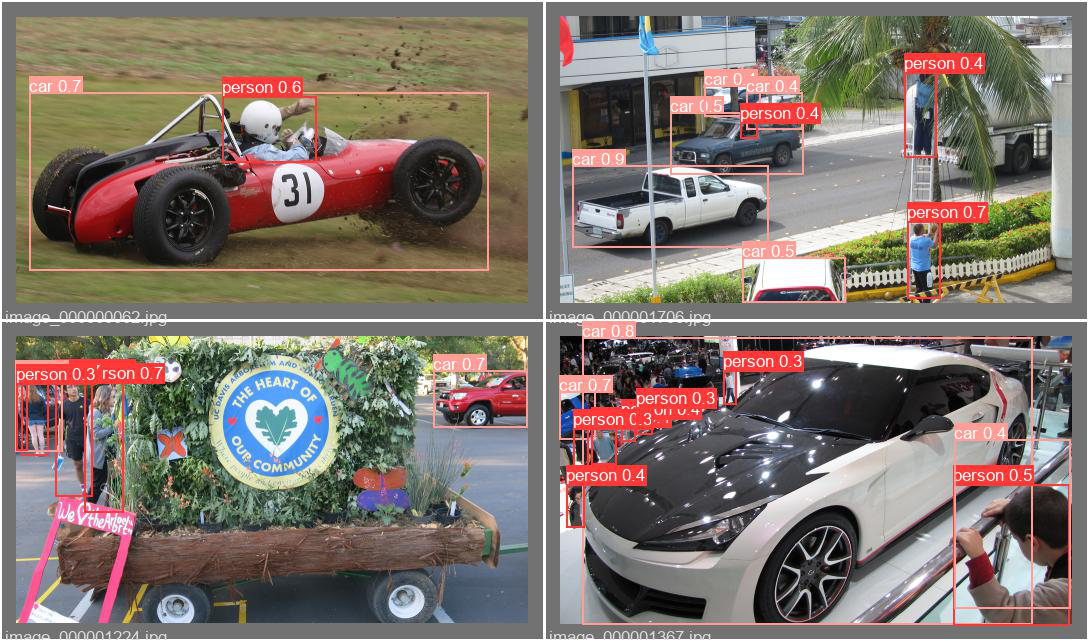

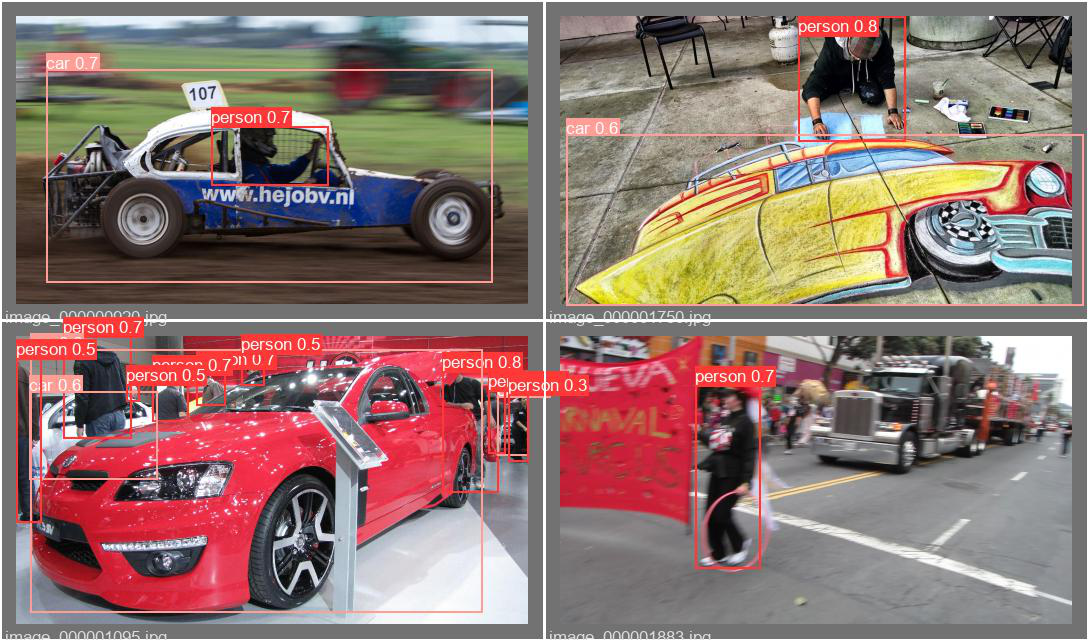

In [ ]:
from PIL import Image

display(Image.open("/content/drive/MyDrive/YOLO/results/eagleview/exp2_5_pt2_val/val_batch0_pred.jpg"))
display(Image.open("/content/drive/MyDrive/YOLO/results/eagleview/exp2_5_pt2_val/val_batch1_pred.jpg"))
display(Image.open("/content/drive/MyDrive/YOLO/results/eagleview/exp2_5_pt2_val/val_batch2_pred.jpg"))

#### Results on the test set

In [ ]:
!python val.py \
--imgsz 512 \
--batch-size 4 \
--data /content/drive/MyDrive/full_data/Modelling_Data/test_data.yaml \
--weights /content/drive/MyDrive/YOLO/eagleview/exp2_5x_pt2/weights/best.pt \
--project results/eagleview \
--name exp2_5x_pt2_test

val: data=/content/drive/MyDrive/full_data/Modelling_Data/test_data.yaml, weights=['/content/drive/MyDrive/YOLO/eagleview/exp2_5x_pt2/weights/best.pt'], batch_size=4, imgsz=512, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=results/eagleview, name=exp2_5x_pt2_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-252-g6a67594 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86180143 parameters, 0 gradients
val: Scanning '/content/drive/MyDrive/full_data/Modelling_Data/test.cache' images and labels... 247 found, 0 missing, 0 empty, 0 corrupt: 100% 247/247 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 62/62 [00:09<00:00,  6.32it/s]
                 all        247       1946      0.774      0.676       0.74      0.453
        

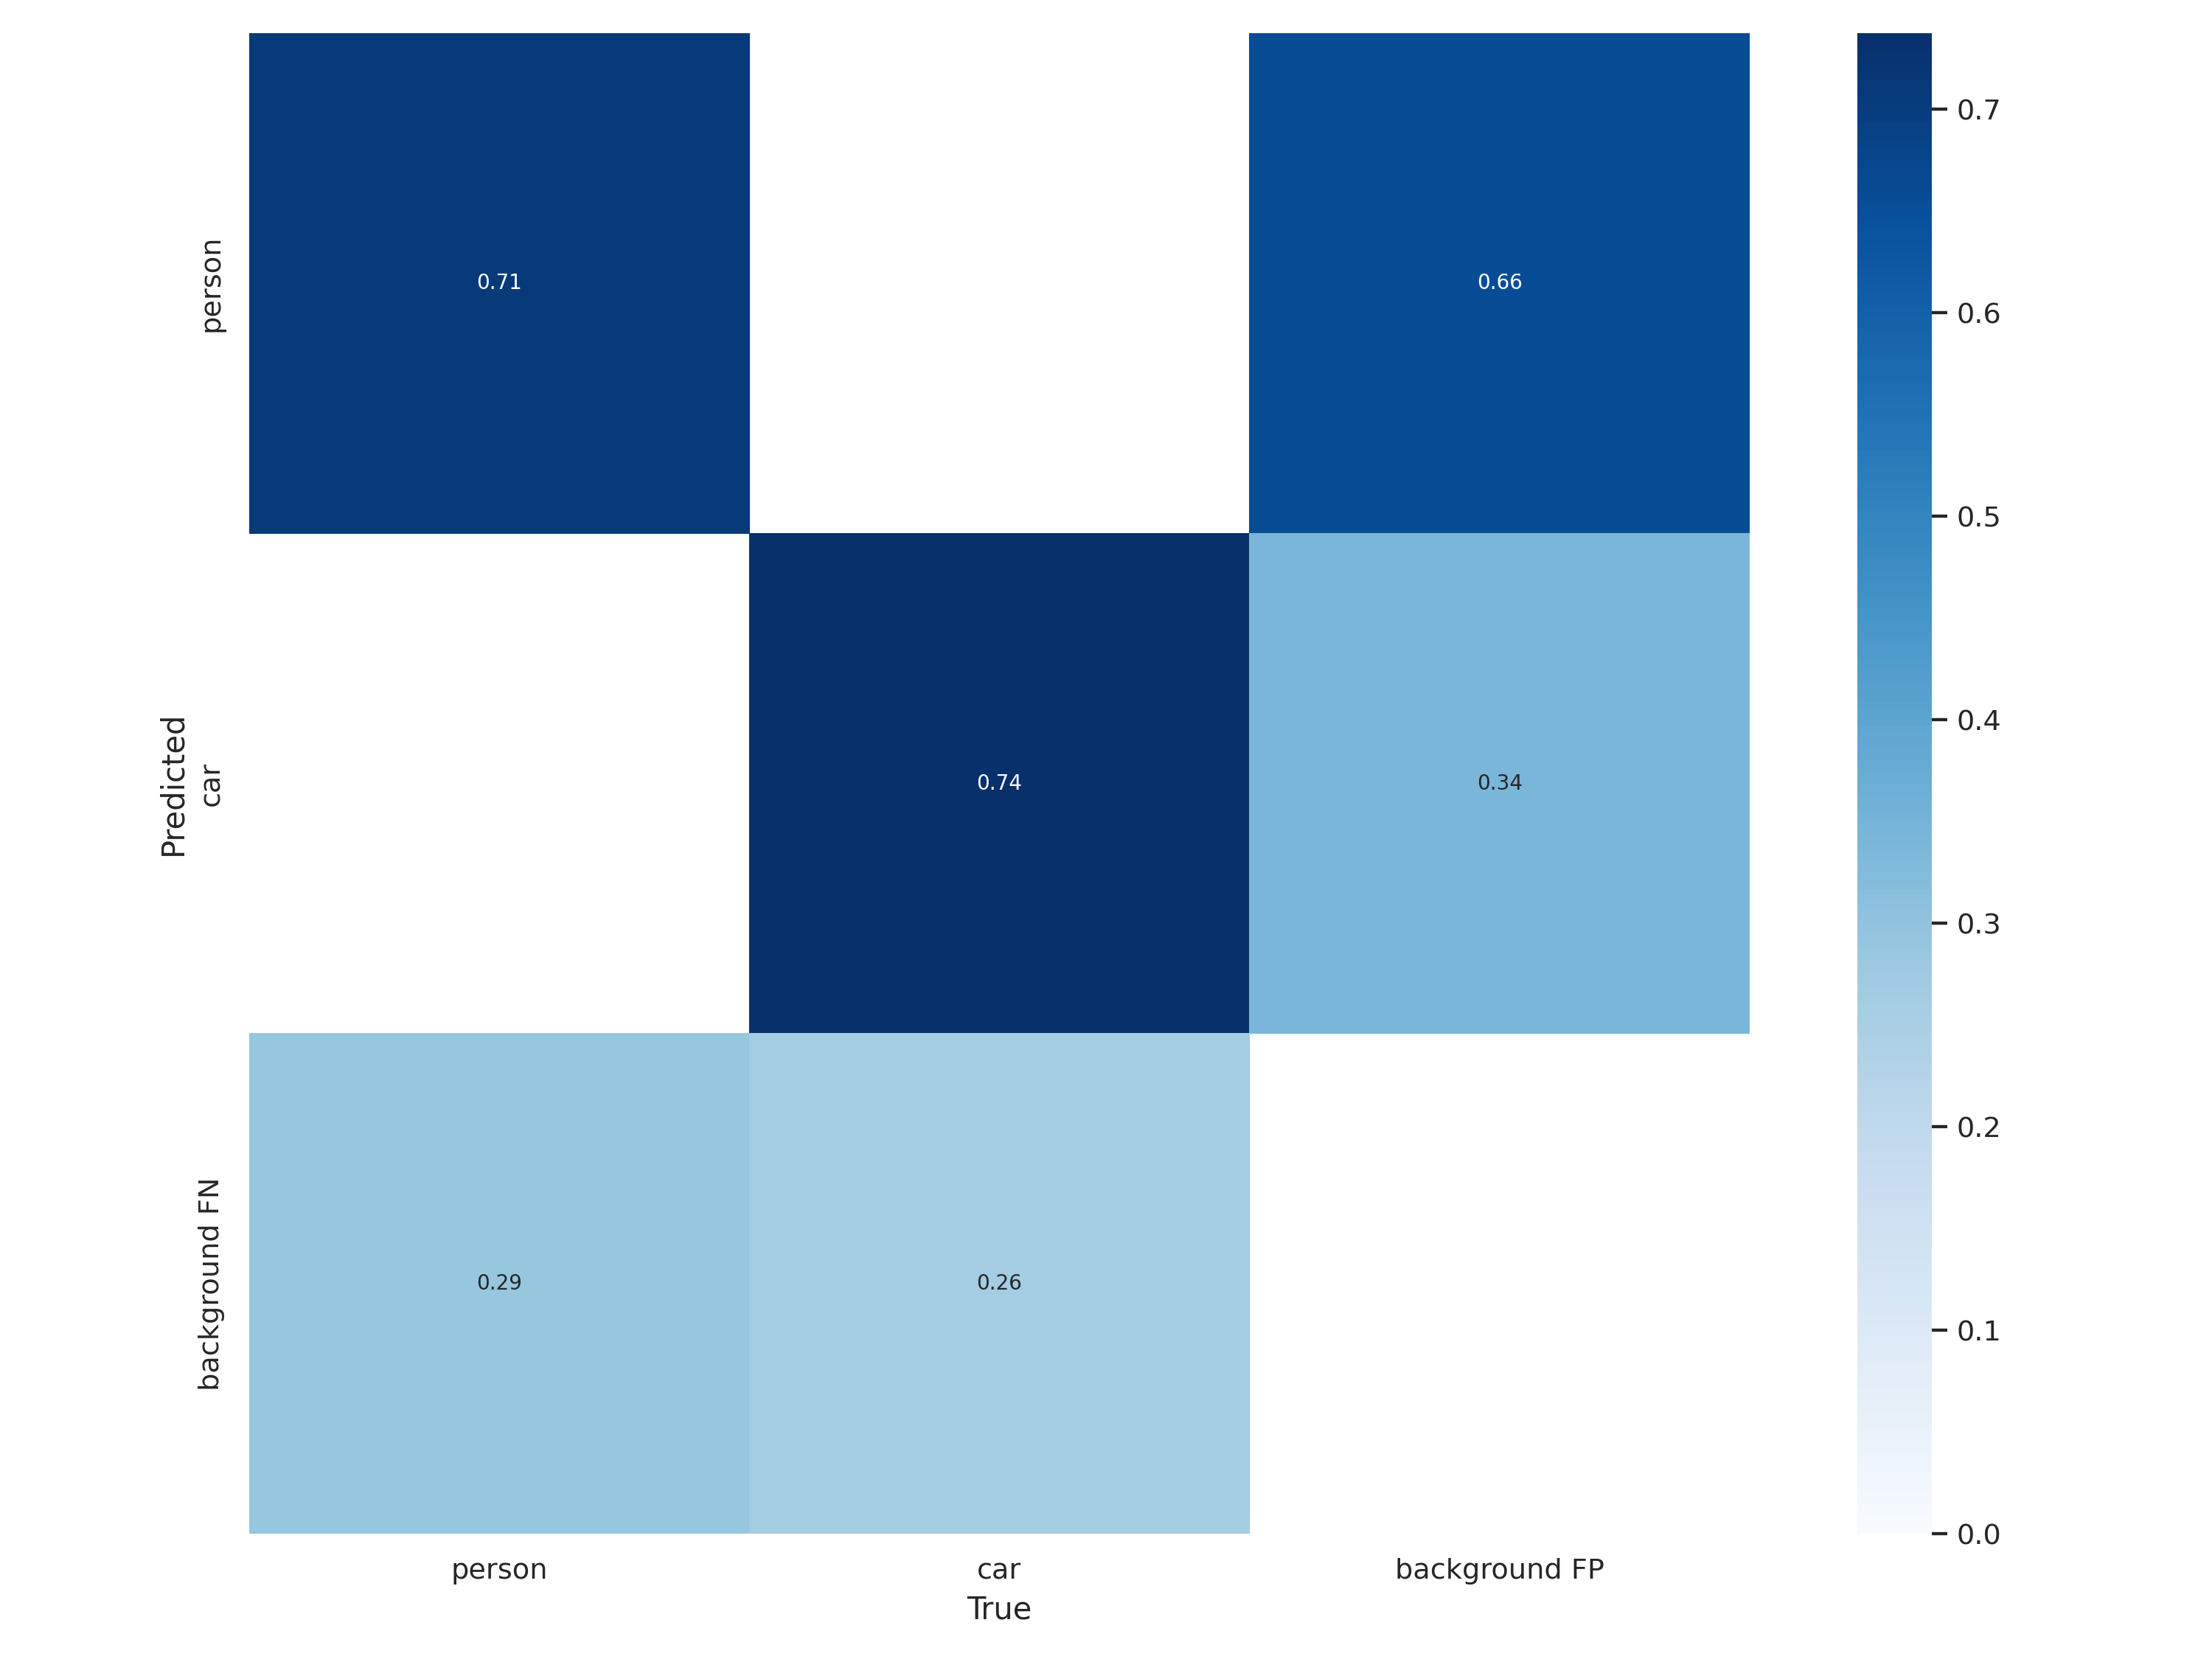

In [ ]:
from PIL import Image

display(Image.open("/content/drive/MyDrive/YOLO/results/eagleview/exp2_5x_pt2_test/confusion_matrix.png"))

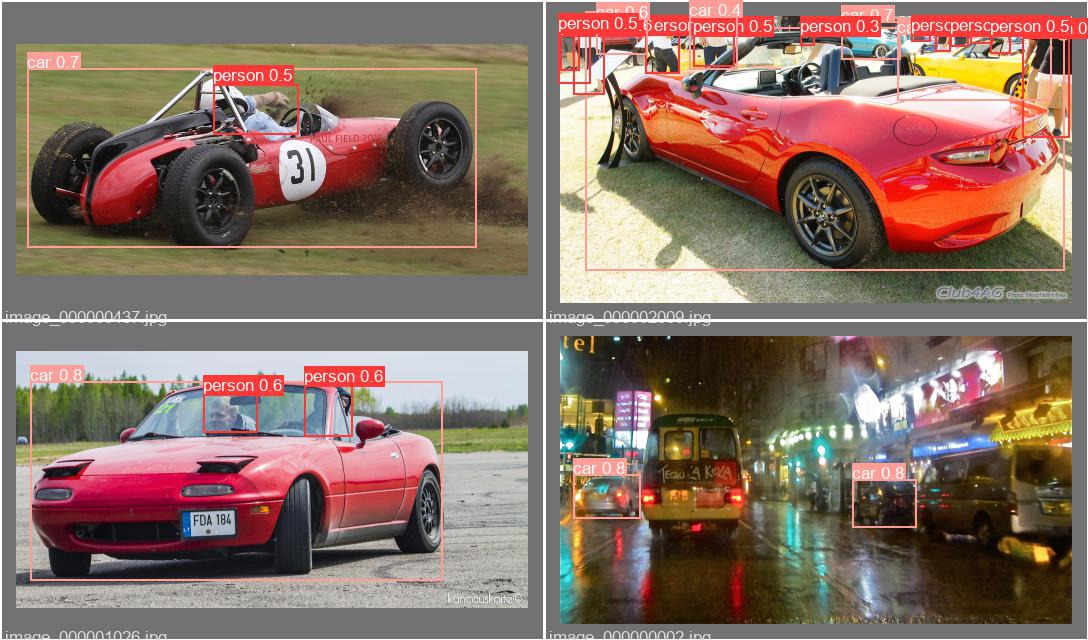

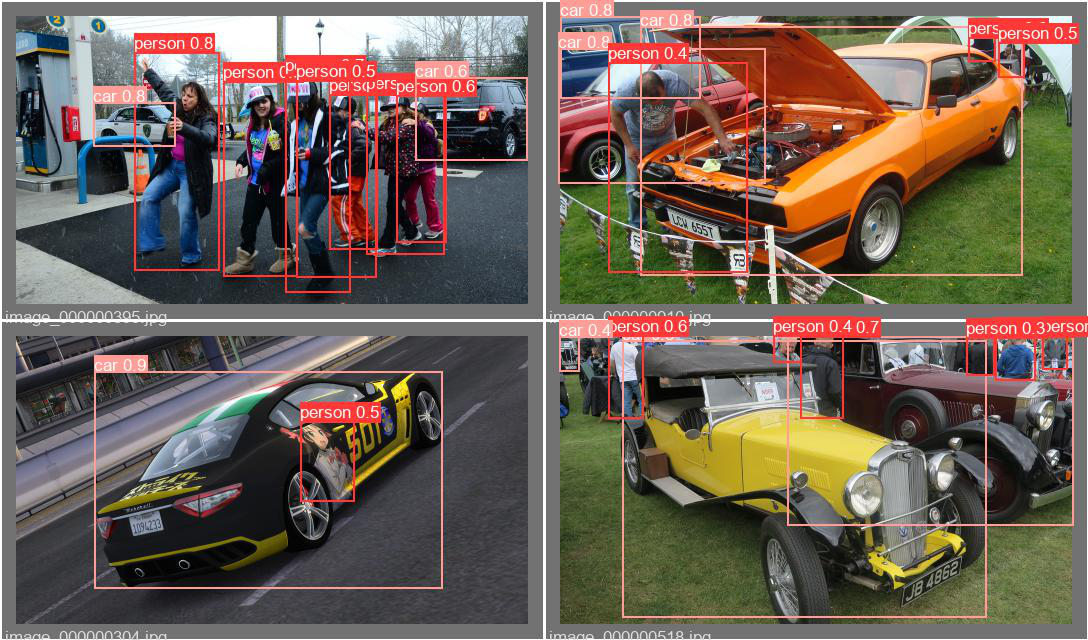

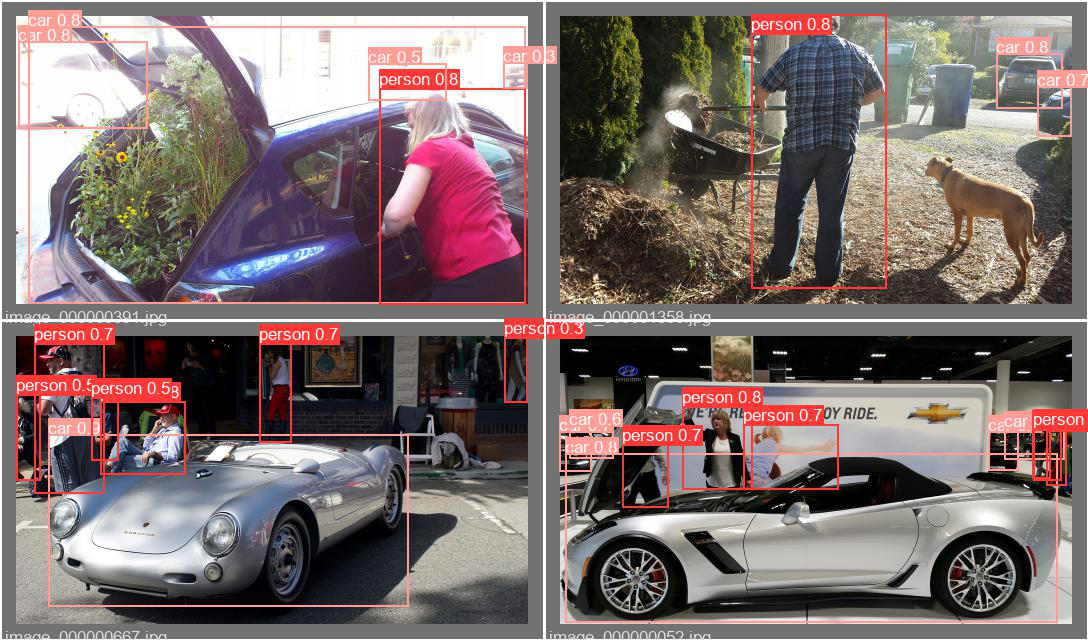

In [ ]:
from PIL import Image

display(Image.open("/content/drive/MyDrive/YOLO/results/eagleview/exp2_5x_pt2_test/val_batch0_pred.jpg"))
display(Image.open("/content/drive/MyDrive/YOLO/results/eagleview/exp2_5x_pt2_test/val_batch1_pred.jpg"))
display(Image.open("/content/drive/MyDrive/YOLO/results/eagleview/exp2_5x_pt2_test/val_batch2_pred.jpg"))